In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [2]:
def identity_block(X, f, filters, training = True):
  '''
  Implements the Identity Block of ResNet50

  Arguments:
  X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -- integer, the kernel size of the 2nd CONV layer of the main path
  filters -- python list of integers, defining the number of filters used in each CONV layer of the main path
  training -- True: Behave in training mode
              False: Behave in inference mode
  
  Returns:
  X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
  '''

  # Save the input value - this will be added back to the main path through skip connection
  X_shortcut = X

  # Get the number of filters of each CONV layer in the main path
  F1, F2, F3 = filters

  # 1st component of the main path
  X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # 2nd component of the main path
  X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # 3rd component of the main path
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X, training = training)

  # Final step: Add shortcut value to the main path, and pass it through ReLU activation
  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [3]:
def convolutional_block(X, f, filters, s = 2, training = True):
  '''
  Implements the Convolutional Block of ResNet50

  Arguments:
  X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
  filters -- python list of integers, defining the number of filters used in each CONV layer of the main path
  f -- integer, specifying the kernel size of the 2nd CONV layer of the main path
  s -- integer, specifying the stride to be used
  training -- True: Behave in training mode
              False: Behave in inference mode
  
  Returns:
  X -- output of the Convolutional Block, tensor of shape (m, n_H, n_W, n_C)
  '''
  # Save the input value - this will be fed into a CONV layer and added back to the main path through skip connection
  X_shortcut = X

  # Get the number of filters of each CONV layer in the main path
  F1, F2, F3 = filters

  # 1st component of the main path
  X = Conv2D(filters = F1, kernel_size = 1, strides = (s,s), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # 2nd component of the main path
  X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # 3rd component of the main path
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X, training = training)

  # Final step: pass the input through CONV layer and add back to the main path, then apply ReLU
  X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid')(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [4]:
def ResNet50(input_shape = (64,64,3), classes = 6):
  '''
  Build model ResNet50, the structure is as follow:
  CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
  -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

  Arguments:
  input_shape -- shape of the images of the dataset
  classes -- integer, number of classes to classify

  Returns:
  model -- a Model() instance in Keras
  '''

  # Define the input
  inputs = Input(input_shape)

  # Zero padding
  X = ZeroPadding2D(padding = (3,3))(inputs)

  # Stage 1
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size = (3,3), strides = (2,2))(X)

  # Stage 2
  X = convolutional_block(X, f = 3, filters = [64,64,256], s = 1)
  X = identity_block(X, f = 3, filters = [64,64,256])
  X = identity_block(X, f = 3, filters = [64,64,256])

  # Stage 3
  X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
  X = identity_block(X, f = 3, filters = [128,128,512])
  X = identity_block(X, f = 3, filters = [128,128,512])
  X = identity_block(X, f = 3, filters = [128,128,512])

  # Stage 4
  X = convolutional_block(X, f = 3, filters = [256,256,1024], s = 2)
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])

  # Stage 5
  X = convolutional_block(X, f = 3, filters = [512,512,2048], s = 2)
  X = identity_block(X, f = 3, filters = [512,512,2048])
  X = identity_block(X, f = 3, filters = [512,512,2048])

  # Average pooling layer
  X = AveragePooling2D(pool_size = (2,2))(X)

  # Flatten layer
  X = Flatten()(X)

  # Output layer
  outputs = Dense(units = classes, activation = 'softmax')(X)

  # Create model
  model = Model(inputs = inputs, outputs = outputs)

  return model 

In [5]:
# Instantiate model
model = ResNet50(input_shape = (64,64,3), classes = 6)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [7]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
import h5py
import numpy as np

# Load dataset
train_dataset = h5py.File('datasets/train_signs.h5', 'r')
test_dataset = h5py.File('datasets/test_signs.h5', 'r')

# Extract training and testing data
train_x, train_y = np.array(train_dataset['train_set_x']), np.array(train_dataset['train_set_y'])
test_x, test_y = np.array(test_dataset['test_set_x']), np.array(test_dataset['test_set_y'])

# Get the classes
classes = np.array(test_dataset['list_classes'])

In [9]:
def convert_to_one_hot(scalar, num_classes):
  '''
  Convert a scalar to an one-hot vector

  Arguments:
  scalar -- the scalar needs to be converted
  num_classes -- the number of classes for converting to one-hot

  Returns:
  one_hot -- the converted one-hot column vector
  '''
  one_hot = np.eye(num_classes)[scalar.reshape(-1)].T
  return one_hot

In [10]:
# Normalize data
train_x = train_x / 255.
test_x = test_x / 255.

In [11]:
# Convert training and test labels to one-hot matrices
num_classes = len(classes)
train_y = convert_to_one_hot(train_y, num_classes).T
test_y = convert_to_one_hot(test_y, num_classes).T

In [12]:
# Inspect the data shapes
print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [13]:
# Train the model
model.fit(train_x, train_y, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 20s 88ms/step - loss: 2.3661 - accuracy: 0.4574
Epoch 2/10
34/34 [==============================] - 2s 59ms/step - loss: 0.6934 - accuracy: 0.7676
Epoch 3/10
34/34 [==============================] - 2s 59ms/step - loss: 0.3916 - accuracy: 0.8611
Epoch 4/10
34/34 [==============================] - 2s 59ms/step - loss: 0.2590 - accuracy: 0.9167
Epoch 5/10
34/34 [==============================] - 2s 59ms/step - loss: 0.0971 - accuracy: 0.9741
Epoch 6/10
34/34 [==============================] - 2s 60ms/step - loss: 0.1401 - accuracy: 0.9565
Epoch 7/10
34/34 [==============================] - 2s 60ms/step - loss: 0.2786 - accuracy: 0.9102
Epoch 8/10
34/34 [==============================] - 2s 60ms/step - loss: 0.1899 - accuracy: 0.9407
Epoch 9/10
34/34 [==============================] - 2s 61ms/step - loss: 0.1033 - accuracy: 0.9667
Epoch 10/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0737 - accuracy: 0.9796


In [14]:
# Evaluate model
preds = model.evaluate(test_x, test_y)
print(f'Loss: {preds[0]}')
print(f'Test Accuracy: {preds[1]}')

4/4 [==============================] - 1s 35ms/step - loss: 0.2674 - accuracy: 0.9083
Loss: 0.26741787791252136
Test Accuracy: 0.9083333611488342


In [18]:
from tensorflow.keras.preprocessing import image 
from matplotlib.pyplot import imshow

def test_on_an_image(img_path, model):

  # Load PIL image
  img = image.load_img(img_path, target_size = (64,64))

  # Convert PIL image to array
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  # Normalize data
  x = x / 255. 
  
  # Show the image
  imshow(img)

  # Test the image against the model
  prediction = model.predict(x)
  
  return prediction

Model's prediction: [2.7298293e-01 4.0486339e-01 1.7499821e-01 1.4804901e-02 1.3234223e-01
 8.3093601e-06]
Label: 1


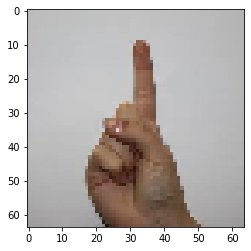

In [21]:
# Test model on an unseen image
prediction = test_on_an_image('sign_digit_1.jpg', model)
print(f"Softmax's prediction on each class:\n {prediction[0]}")
print(f"Label: {np.argmax(prediction)}")